# AI agent for text analysis

In this notebook, we will build an AI agent that can analyze text step-by-step using a set of specialized language model capabilities. Instead of relying on a single prompt to handle everything, we are creating an agent that breaks down complex text analysis into discrete, sequential steps - each handled by a specialized function.

Our AI agent follows the prompt chaining design pattern, where the output of one AI operation becomes the input for the next. This creates a pipeline of interconnected AI capabilities that work together to achieve a more comprehensive analysis than any single prompt could provide.

The agent we are building has three core capabilities:
1. Text classification - Categorizing content type.
2. Entity extraction - Identifying key people, places, and organizations.
3. Text summarization - Distilling key information.

Each of these steps will be implemented as a separate function (or “node”) in a graph-based workflow, allowing us to manage execution order and shared memory between steps. We will use LangGraph as our orchestration framework to manage the flow between these capabilities and maintain state throughout the process, and LangChain for prompt templating and calling LLMs.

In [1]:
import os
from typing import TypedDict, List
from langgraph.graph import StateGraph, END
from langchain.prompts import PromptTemplate
from langchain_openai import ChatOpenAI
from langchain.schema import HumanMessage
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image

from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Configure OpenAI API key for AI model access
os.environ["OPENAI_API_KEY"] = os.getenv('OPENAI_API_KEY')

* **`LangGraph`**: Provides the framework to define and orchestrate our agent’s workflow as a directed graph of functions (nodes).
* **`LangChain`**: Used to build and format prompts, and interface with OpenAI's language models in a structured way.
* **`PromptTemplate`**: Allows us to define reusable prompt strings with variable substitution.
* **`HumanMessage`**: Represents a message in a chat-like context, simulating a human input. This is useful because OpenAI chat models expect input in the form of a sequence of role-based messages (`system`, `user`, `assistant`). `HumanMessage` explicitly defines a message as coming from a user.
* **`TypedDict` / `List`**: From Python’s typing system — these are used to define structured, type-safe data that will act as our agent’s internal memory (or “state”).


## Building the text processing pipeline

### LLM initialization
We now initialize the core language model that the agent will use to perform its tasks.

In [2]:
# Initialize the language model with deterministic behavior
llm = ChatOpenAI(model="gpt-4o-mini-2024-07-18", temperature=0)

We create our AI model instance with temperature setting of 0 ensures our agent produces consistent, reproducible results rather than creative variations - important for reliable text analysis. This model will be shared across all three capabilities of our agent.


### Agent state definition (working memory)
For our AI agent to work across multiple stages — classification, entity extraction, and summarization — it needs a way to store and share data across those steps. That’s where the concept of *state* comes in. We define a shared state, the internal data that flows through the graph. This acts as the agent's "memory" and data exchange format between capabilities, that holds both the original input text and the outputs from each step along the pipeline.

Each function (node) in our graph will:
- Read from the state to get the input it needs.
- Return an updated piece of the state as its output.

In [3]:
# Define the shared data structure used across nodes
class State(TypedDict):
    text: str  # Original input text to analyze
    classification: str  # Category assigned by classification capability
    entities: List[str]  # List of entities found by extraction capability
    summary: str  # Condensed summary from summarization capability

This State class defines our agent's internal data structure and gives us a consistent schema for the data passed between nodes in the LangGraph workflow. Each node will receive a dictionary matching this structure. When a node finishes its job, it returns a partial update to this structure — for example, when the classification node runs, it reads from `state["text"]` and will just return {"classification": ...}  to `state["classification"]` and leave the rest untouched. The next node—entity extraction—can read that same text and add its output to `state["entities"]`, and so on.

This allows LangGraph to merge updates from each step and carry them forward, gradually enriching the state as the agent moves through each capability.

To make this state clear and enforce good structure, we define it using Python’s TypedDict. This gives us the benefits of:
- Type safety during development.
- A clear contract for what data each capability should expect.
- A centralized, extensible way to manage intermediate results.

By centralizing our state in this way, we make the system easier to reason about, more modular, and highly scalable if we ever decide to add more capabilities in the future (e.g., sentiment analysis, keyword extraction, etc.).


### Agent nodes capabilitiy definitions
Here we define the three core capabilities that make up our AI agent. Each node in our LangGraph represents a single skill or sub-agent in the larger agent system. These are built using prompt templates that invoke the language model.

#### Text classification node
This capability enables our agent to understand what type of content it's analyzing, which can inform downstream processing decisions. This step is helpful because the type of content can influence how we interpret the text or what downstream operations might make sense. For example, entity extraction might behave differently on informal blog content than on structured research papers.

In [4]:
def classification_node(state: State):
    ''' Classify the text into one of the categories: News, Blog, Research, or Other '''
    # Create a focused prompt for classification task
    prompt = PromptTemplate(
        input_variables=["text"],
        template="Classify the following text into one of the categories: News, Blog, Research, or Other.\n\nText:{text}\n\nCategory:"
    )
    # Convert prompt to message format for the AI model
    message = HumanMessage(content=prompt.format(text=state["text"]))
    # Invoke AI model and process response
    classification = llm.invoke([message]).content.strip()
    # Return result in state format for next capability
    return {"classification": classification}

This function implements our agent's first capability using a prompt that constrains the AI model to specific categories. The structured approach ensures consistent outputs that other parts of our system can rely on. The function:
- Reads the raw input text from the shared state.
- Uses a `PromptTemplate` to ensure consistency and clarity in how we ask the model to classify the text. It applies zero-shot classification via the prompt.
- Wraps that prompt in a `HumanMessage` — this tells the language model that the message should be treated as if it were written by a user. (This is important because OpenAI chat models expect multi-role input, and `HumanMessage` ensures the prompt fits that expected format.)
- Calls the language model synchronously and extracts the clean classification label from its response.
- Returns the result as a dictionary with the key `"classification"`, which LangGraph will merge into the shared memory.

The output is now available for any downstream capability that depends on knowing what kind of text it's dealing with — making the agent smarter, context-aware, and easier to extend.

#### Entity extraction node
Once the agent understands what type of content it’s analyzing, the next step is to dig deeper and extract meaningful details from the text — specifically, who and what the text is about. This capability gives our agent the ability to identify and extract key entities from text, providing structured information about people, places, and organizations mentioned.

In traditional NLP pipelines, this would require a trained model or a dedicated library. But in our agent design, we take an agentic approach: we use a language model to handle this task via a purpose-built prompt.

In [5]:
def entity_extraction_node(state: State):
    ''' Extract all the entities (Person, Organization, Location) from the text '''
    # Create targeted prompt for entity extraction
    prompt = PromptTemplate(
        input_variables=["text"],
        template="Extract all the entities (Person, Organization, Location) from the following text. Provide the result as a comma-separated list.\n\nText:{text}\n\nEntities:"
    )
    # Format and send to AI model
    message = HumanMessage(content=prompt.format(text=state["text"]))
    # Process AI response into structured list format
    entities = llm.invoke([message]).content.strip().split(", ")
    # Return structured entities for agent's state
    return {"entities": entities}

This function implements entity recognition by prompting the AI model to identify specific types of entities and return them in a structured format.
- The prompt focuses the model on just three common NER types: persons, organizations, and locations. This helps reduce ambiguity and keeps results reliable.
- By instructing the model to output a comma-separated list, we create a predictable output format that we can easily parse into a Python list.
- The model’s raw text output is stripped of whitespace and parsed into a clean list of strings.
- That list is then returned in the `entities` field of the shared state, making it available for use by later stages (or external systems).


#### Summarization node
The final capability enables our agent to distill the key information from the input text into a concise summary.

This is particularly useful in real-world applications where high-level overviews are needed quickly — such as news aggregation, content previewing, or customer service workflows.

In [6]:
def summarization_node(state: State):
    ''' Summarize the text in one short sentence '''
    # Create summary-focused prompt with length constraint
    prompt = PromptTemplate(
        input_variables=["text"],
        template="Summarize the following text in one short sentence.\n\nText:{text}\n\nSummary:"
    )
    # Process through AI model
    message = HumanMessage(content=prompt.format(text=state["text"]))
    # Extract clean summary text
    summary = llm.invoke([message]).content.strip()
    # Return summary for final agent output
    return {"summary": summary}

This function completes our agent's capability set by providing text summarization.
- The prompt explicitly instructs the model to return a single sentence. This is a soft constraint enforced by phrasing, not a hard character limit — but it usually works well with GPT models.
- The prompt is wrapped in a `PromptTemplate` object, allowing us to reuse and format it safely using state values.
- The formatted prompt is converted to a `HumanMessage`, which standardizes the input format expected by the LLM.
- We then call the model using `.invoke()` and clean up the returned text.
- The result is returned as a dictionary with the key `summary`, ready to be merged into the shared agent state.


### Agent workflow construction
Now we will assemble our AI agent by connecting the capabilities in a logical sequence. This is where LangGraph comes in. It allows us to declaratively connect each node into a graph, forming a clear flow of logic. In this case, we are using the prompt chaining design pattern where each capability builds upon the previous ones and operates over shared state.

In [7]:
# Create the agent workflow using StateGraph
workflow = StateGraph(State)

# Add nodes to the graph
workflow.add_node("classification_node", classification_node)
workflow.add_node("entity_extraction", entity_extraction_node)
workflow.add_node("summarization", summarization_node)

# Add edges to the graph - define the execution flow (prompt chains)
workflow.set_entry_point("classification_node")  # Set the entry point of the graph
workflow.add_edge("classification_node", "entity_extraction")  # Then moves to entity extraction
workflow.add_edge("entity_extraction", "summarization")  # Then creates summary
workflow.add_edge("summarization", END)  # Finally completes processing

# Compile the graph into an executable agent
app = workflow.compile()

This block turns our standalone AI functions into a connected, executable multi-stage agent.
- We start by creating a `StateGraph`, which handles state transitions between nodes. Each node works with the `State` we defined earlier.
- The `add_node()` calls register our capability functions in the graph with logical names. These names are how we refer to them when wiring the flow.
- The `add_edge()` calls define the control flow between nodes — in other words, the order in which tasks should run. This effectively implements our prompt chain: each task happens after the previous one finishes and updates state.
- `set_entry_point()` tells LangGraph where the agent should begin execution.
- `workflow.compile()` transforms the structure into a runnable object that behaves like a callable function — it takes input, moves through the steps, and produces output.

The workflow defines the exact sequence of operations (prompt chaining), ensuring each capability receives the necessary input and contributes to the overall analysis. The compiled agent can now process text through all three capabilities automatically while maintaining state throughout the process.


## Visualizing the workflow
Let's visualize our AI agent's internal structure to better understand how the capabilities connect and data flows through the system.

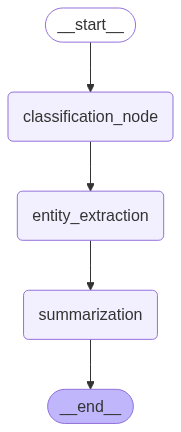

In [8]:
# Generate visual representation of our AI agent's workflow
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

This visualization code generates a flowchart showing our agent's internal structure. This is useful for debugging and documentation.

## Testing the agent pipeline
Finally, let's test our AI agent with sample text to see all capabilities working together in the prompt chaining sequence and how each skill contributes to the overall understanding.

In [9]:
# Example input text to process
sample_text = """
OpenAI has announced the GPT-4 model, which is a large multimodal model that exhibits human-level performance on various professional benchmarks. It is developed to improve the alignment and safety of AI systems.
additionally, the model is designed to be more efficient and scalable than its predecessor, GPT-3. The GPT-4 model is expected to be released in the coming months and will be available to the public for research and development purposes.
"""

# Prepare input for our AI agent
state_input = {"text": sample_text}

# Execute the complete agent workflow
result = app.invoke(state_input)

# Display outputs from each stage
print("Classification:", result["classification"])
print("\nEntities:", result["entities"])
print("\nSummary:", result["summary"])

Classification: News

Entities: ['OpenAI', 'GPT-4', 'GPT-3']

Summary: OpenAI's upcoming GPT-4 model is a multimodal AI that aims for human-level performance, improved safety, and greater efficiency compared to GPT-3.


This test demonstrates our complete AI agent in action. The sample text is processed through all three capabilities sequentially - classification identifies it as news, entity extraction finds organizations and concepts mentioned, and summarization distills the key message. The results show how prompt chaining enables comprehensive analysis that is more thorough than a single AI interaction could provide.